In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%cd ..

/jupyter-lab/repo/bigstar


# Import Modules

In [127]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

import pickle
from collections import Counter
from functools import partial
from pathlib import Path
from typing import Dict, Iterable, Tuple

import joblib
import matplotlib.pyplot as plt
import mecab_ko as mecab
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import scipy.special as sp
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from nlpaug.util import Action
from scipy.sparse import csr_matrix
from scipy.special import softmax
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from src.base_trainer import get_ckpt_path, get_model_hparams, load_model_state
from src.baseline.models import BaselineModel, BaselineModelWithMLAttention
from src.baseline.trainer import BaselineTrainerModel
from src.datasets import LotteQADataset, collate_fn
from src.eda import EDA
from src.utils import (
    delete_list_elements,
    filter_arguments,
    get_label_encoder,
    get_n_samples,
)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoTokenizer,
    MarianMTModel,
)
from transformers.models.marian.convert_marian_to_pytorch import (
    load_config_from_state_dict,
)
from transformers.tokenization_utils_base import PreTrainedTokenizerBase

plt.rcParams["font.family"] = "NanumGothic"

# Functions

In [93]:
def predict(run_id, **dataset_kwargs):
    ckpt_path = get_ckpt_path(log_dir="./logs", run_id=run_id, load_best=True)
    model_hparams = get_model_hparams(
        "./logs", run_id, BaselineTrainerModel.MODEL_HPARAMS
    )
    le = get_label_encoder("./cache/label_encoder.joblib")

    model_cls = (
        BaselineModel
        if model_hparams["model_name"] == "Baseline"
        else BaselineModelWithMLAttention
    )

    model = model_cls(
        num_labels=len(le.classes_), **filter_arguments(model_hparams, model_cls)
    )

    load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

    test_dataset = LotteQADataset(**dataset_kwargs)
    tokenizer = AutoTokenizer.from_pretrained(model_hparams["pretrained_model_name"])
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=16,
        pin_memory=True,
        num_workers=4,
        collate_fn=partial(
            collate_fn,
            tokenizer=tokenizer,
            le=le,
            max_length=model_hparams["max_length"],
        ),
    )

    device = torch.device("cuda")

    model.to(device)
    model.eval()
    logits = []

    for batch_x, batch_y in tqdm(test_dataloader):
        batch_x = {k: v.to(device) for k, v in batch_x.items()}
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(batch_x)
        logits.append(outputs.cpu())

    logits = np.concatenate(logits)
    predictions = logits.argmax(axis=-1)

    gt = le.transform(test_dataset.y)
    f1_micro = f1_score(gt, predictions, average="micro")
    prec_macro, recall_macro, f1_macro, support = precision_recall_fscore_support(
        gt,
        predictions,
        average="macro",
        zero_division=0,
    )
    prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        gt,
        predictions,
        average="weighted",
        zero_division=0,
    )
    prec, recall, f1, _ = precision_recall_fscore_support(
        gt, predictions, average=None, zero_division=0
    )

    print(f"f1        (micro): {f1_micro:.4f}")
    print(f"prec      (macro): {prec_macro:.4f}")
    print(f"recall    (macro): {recall_macro:.4f}")
    print(f"f1        (macro): {f1_macro:.4f}")
    print(f"prec   (weighted): {prec_weighted:.4f}")
    print(f"recall (weighted): {recall_weighted:.4f}")
    print(f"f1     (weighted): {f1_weighted:.4f}")

    matrix = confusion_matrix(gt, predictions)

    data = {
        "intent": le.classes_,
        "support": matrix.sum(axis=-1),
        "# to tp": np.diag(matrix),
        "# of predicted": matrix.sum(axis=0),
    }

    df = pd.DataFrame(data)

    return {
        "df": df,
        "matrix": matrix,
        "f1_micro": f1_micro,
        "prec_macro": prec_macro,
        "recall_macro": recall_macro,
        "prec_weighted": prec_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "prec": prec,
        "recall": recall,
        "f1": f1,
        "gt": gt,
        "predictions": predictions,
        "logits": logits,
    }


def plot_label_distribution(df, key="인텐트", columns=None, figsize=(12, 4), **kwargs):
    value_counts = df[key].value_counts()
    if columns is not None:
        value_counts = value_counts.loc[columns]
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set(**kwargs)
    sns.barplot(x=value_counts.index, y=value_counts.to_numpy(), ax=ax)

# Load Dataset

In [121]:
train_df = LotteQADataset().df
val_df = LotteQADataset(mode="val").df
test_df = LotteQADataset(mode="test").df
le = get_label_encoder("cache/label_encoder.joblib")
mlb = get_label_encoder("cache/label_encoder_mlb.joblib", is_multilabel=True)

# Analysis

In [4]:
results = joblib.load("outputs/pred.joblib")
results1 = results[0]  # Baseline prediction (test set)
results2 = results[1]  # Prediction trained with augmented train+back.v9 (test set)
results3 = results[2]  # Prediction trained with original (back.v1)

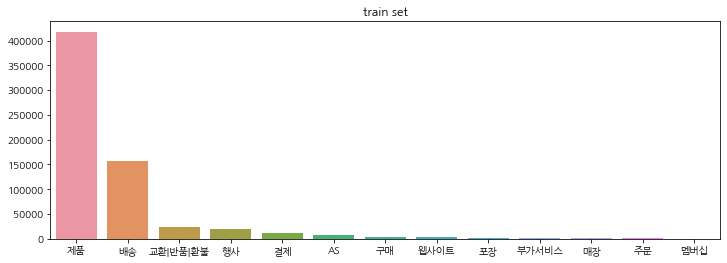

In [39]:
plot_label_distribution(train_df, title="train set")

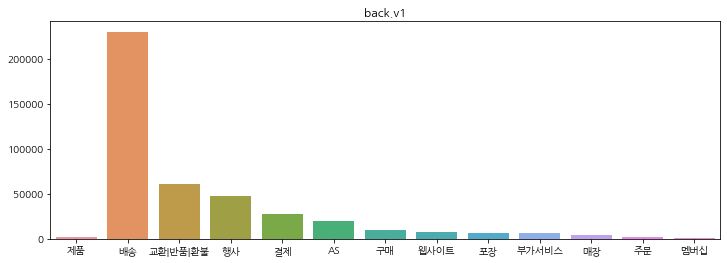

In [40]:
back_v1_df = pd.read_csv("data/back.v1.csv")
columns = train_df['인텐트'].value_counts().index
plot_label_distribution(back_v1_df, columns=columns, title="back.v1")

In [41]:
train_back_v10_results = predict(run_id="d44ead9cc64f42a480fa728ce63025a0", mode="test")
train_back_v10_results["df"].to_excel("outputs/predictions.xlsx", index=False)

  0%|          | 0/5301 [00:00<?, ?it/s]

f1        (micro): 0.9306
prec      (macro): 0.6867
recall    (macro): 0.5975
f1        (macro): 0.6195
prec   (weighted): 0.9276
recall (weighted): 0.9306
f1     (weighted): 0.9281


In [42]:
# Baseline
train_results = predict(run_id="d44ead9cc64f42a480fa728ce63025a0", mode="train")

  0%|          | 0/40813 [00:00<?, ?it/s]

f1        (micro): 0.9333
prec      (macro): 0.7475
recall    (macro): 0.6330
f1        (macro): 0.6575
prec   (weighted): 0.9299
recall (weighted): 0.9333
f1     (weighted): 0.9301


In [87]:
# BaselineWithMLAttention
train_results2 = predict(run_id="f19847f8ba794b2492f184ee8f26ba9e", mode="train")

  0%|          | 0/40813 [00:00<?, ?it/s]

f1        (micro): 0.9398
prec      (macro): 0.7373
recall    (macro): 0.6057
f1        (macro): 0.6461
prec   (weighted): 0.9346
recall (weighted): 0.9398
f1     (weighted): 0.9351


In [103]:
logits = (train_results["logits"] + train_results2["logits"]) / 2
gt = train_results["gt"]
predictions = logits.argmax(axis=-1)
matrix = confusion_matrix(train_results["gt"], predictions)

f1_micro = f1_score(gt, predictions, average="micro")
prec_macro, recall_macro, f1_macro, support = precision_recall_fscore_support(
    gt,
    predictions,
    average="macro",
    zero_division=0,
)
prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    gt,
    predictions,
    average="weighted",
    zero_division=0,
)
prec, recall, f1, _ = precision_recall_fscore_support(
    gt, predictions, average=None, zero_division=0
)

print(f"f1        (micro): {f1_micro:.4f}")
print(f"prec      (macro): {prec_macro:.4f}")
print(f"recall    (macro): {recall_macro:.4f}")
print(f"f1        (macro): {f1_macro:.4f}")
print(f"prec   (weighted): {prec_weighted:.4f}")
print(f"recall (weighted): {recall_weighted:.4f}")
print(f"f1     (weighted): {f1_weighted:.4f}")

pd.DataFrame(
    {
        "intent": le.classes_,
        "support": matrix.sum(axis=-1),
        "# to tp": np.diag(matrix),
        "# of predicted": matrix.sum(axis=0),
    }
)

f1        (micro): 0.9392
prec      (macro): 0.7374
recall    (macro): 0.6216
f1        (macro): 0.6594
prec   (weighted): 0.9345
recall (weighted): 0.9392
f1     (weighted): 0.9351


,intent,support,# to tp,# of predicted
0,AS,8261,6511,8207
1,결제,11332,4220,6175
2,교환|반품|환불,23707,20773,24559
3,구매,4088,2265,2679
4,매장,2059,1522,1689
5,멤버십,404,164,233
6,배송,156965,150736,160571
7,부가서비스,2578,1385,1815
8,웹사이트,3089,482,860
9,제품,417927,406276,423079


In [89]:
train_results['df']

,intent,support,# to tp,# of predicted
0,AS,8261,6604,8761
1,결제,11332,4339,6810
2,교환|반품|환불,23707,20563,25261
3,구매,4088,2303,2907
4,매장,2059,1497,1718
5,멤버십,404,208,356
6,배송,156965,150939,162666
7,부가서비스,2578,1386,1870
8,웹사이트,3089,606,1264
9,제품,417927,402229,417873


In [88]:
train_results2['df']

,intent,support,# to tp,# of predicted
0,AS,8261,6326,7816
1,결제,11332,4029,5960
2,교환|반품|환불,23707,20627,24237
3,구매,4088,2186,2577
4,매장,2059,1508,1706
5,멤버십,404,137,206
6,배송,156965,149654,158176
7,부가서비스,2578,1379,1913
8,웹사이트,3089,351,577
9,제품,417927,408524,426987


In [104]:
incorrect = np.where(train_results['gt'] != train_results['predictions'])[0]
pd.DataFrame(train_df.iloc[incorrect]['인텐트'].value_counts())

,인텐트
제품,15698
결제,6993
배송,6026
교환|반품|환불,3144
행사,2658
웹사이트,2483
구매,1785
AS,1657
부가서비스,1192
주문,749


In [105]:
df = train_df.loc[incorrect]
probs = sp.softmax(train_results["logits"][incorrect].astype(np.float32), axis=-1).max(
    axis=-1
)
df["prediction"] = le.classes_[train_results["predictions"][incorrect]]
df["probs"] = probs
df

,발화문,인텐트,prediction,probs
3,레이스 커튼만 개별 구매 안 될까요?,구매,제품,0.486534
5,화이트 구매 안 되나요?,구매,제품,0.544645
6,주문 가능할까요?,주문,제품,0.441103
22,왜 사진과 다르게 보냇는지요?,제품,배송,0.594747
44,제가 잘못 이해하고 주문한 걸까요?,주문,결제,0.686396
...,...,...,...,...
652851,이럴 경우 어떻게 해야 하나요?,결제,교환|반품|환불,0.275573
652872,속지 추가 시 따로 오는 건가요?,제품,배송,0.719898
652886,"참, 일주일 간격으로 두 번 주문한 건데 앨범 두 개 구매로 서비스 앨범 주시면 안...",제품,행사,0.905092
652899,2센티220 보슬이 10개 5센티 80까슬이 2개 맞죠?,결제,제품,0.941553


In [107]:
df[(df['probs'] >= 0.95)]

,발화문,인텐트,prediction,probs
605,선물하려고 하는데 선물용 가방을 같이 주문할 수 있을까요?,구매,포장,0.977137
772,타이백 포함인가요?,행사,제품,0.995800
1369,4개 수량 넣으면 가로 사이즈 맞는 두 폭이 오나요?,구매,제품,0.956051
1474,플레르 레이스 속 커튼이랑 같이 구매했는데요가로 280 세로 230레이스 커튼은 봉...,부가서비스,제품,0.973338
1635,커튼만 오나요?,배송,제품,0.959226
...,...,...,...,...
652012,물건은 잘 받았는데 타임스케줄은 안 들어 있던데요 누락된 건가요?,제품,배송,0.967219
652224,교환신청했는데 택배기사님이 안 가져가 시네요?,배송,교환|반품|환불,0.990882
652233,교환신청했습니다 택배 사 접수가 바로 되나요?,배송,교환|반품|환불,0.977312
652329,하나가 빈칸으로 왔어요 빈칸은 뭐죠?,제품,배송,0.968549


# GPT2

In [669]:
pretrained_model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name)

In [707]:
text = "주문"
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[16812]]), 'attention_mask': tensor([[1]])}

In [ ]:
model.to(device)

In [726]:
%%time
gen_ids = model.generate(
    **inputs,
    max_length=128,
    repetition_penalty=2.0,
)
generated = tokenizer.batch_decode(gen_ids)
print(generated[0])

주문했다.
이날 오전 9시30분께 서울 종로구 세종로 정부중앙청사 별관 2층 회의실에서 열린 이 전 대통령과의 독대에서는 김백준 총무기획관이 "대통령께서 (김대중)전 대통령의 서거에 대해 애도를 표하고 유족들에게 위로의 말씀을 드린다"고 말했다.
이어 "이번 사태는 김대중 대통령이 지난해 12월19일 대국민담화에서 밝힌 대로 국민통합과 국가발전을 위해 혼신의 노력을 다하는 과정에서 발생한 것"이라며 이같이 밝혔다.
그는 또 박근혜 한나라당 대표의 '독도 방문과 관련,'박 대표가 직접 나서야 한다는 주장에 대해서는 일축
CPU times: user 2min 17s, sys: 77.2 ms, total: 2min 17s
Wall time: 3.87 s


In [723]:
sorted(tokenizer.get_vocab().items(), key=lambda key: key[1])

[('<s>', 0),
 ('</s>', 1),
 ('<usr>', 2),
 ('<pad>', 3),
 ('<sys>', 4),
 ('<unk>', 5),
 ('<mask>', 6),
 ('<d>', 7),
 ('</d>', 8),
 ('<unused0>', 9),
 ('<unused1>', 10),
 ('<unused2>', 11),
 ('<unused3>', 12),
 ('<unused4>', 13),
 ('<unused5>', 14),
 ('<unused6>', 15),
 ('<unused7>', 16),
 ('<unused8>', 17),
 ('<unused9>', 18),
 ('<unused10>', 19),
 ('<unused11>', 20),
 ('<unused12>', 21),
 ('<unused13>', 22),
 ('<unused14>', 23),
 ('<unused15>', 24),
 ('<unused16>', 25),
 ('<unused17>', 26),
 ('<unused18>', 27),
 ('<unused19>', 28),
 ('<unused20>', 29),
 ('<unused21>', 30),
 ('<unused22>', 31),
 ('<unused23>', 32),
 ('<unused24>', 33),
 ('<unused25>', 34),
 ('<unused26>', 35),
 ('<unused27>', 36),
 ('<unused28>', 37),
 ('<unused29>', 38),
 ('<unused30>', 39),
 ('<unused31>', 40),
 ('<unused32>', 41),
 ('<unused33>', 42),
 ('<unused34>', 43),
 ('<unused35>', 44),
 ('<unused36>', 45),
 ('<unused37>', 46),
 ('<unused38>', 47),
 ('<unused39>', 48),
 ('<unused40>', 49),
 ('<unused41>', 50),